## 1. 时间序列

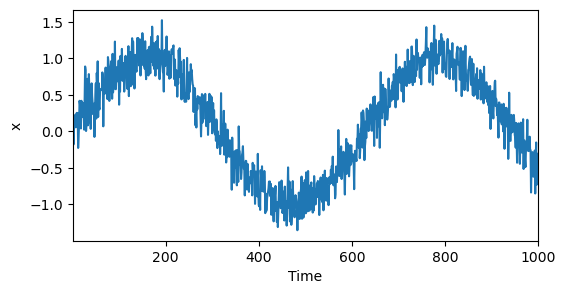

In [21]:
%matplotlib inline
# 1.1 构建数据点

import torch
from torch import nn
import matplotlib.pyplot as plt
from ml_model_utils import *

T = 1000  # 总共产生1000个点
time_steps = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time_steps) + torch.normal(0, 0.2, (T,))

plt.plot(time_steps, x)  # 正确：传入 x 和 y
plt.xlabel("Time")       # 设置横坐标名称
plt.ylabel("x")          # 设置纵坐标名称
plt.xlim([1, 1000])      # 设置横轴范围
plt.gcf().set_size_inches(6, 3)  # 设置图像大小
plt.show()

In [2]:
# 1.2 构建数据集。 特征-标签 对

tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

`nn.init.xavier_uniform_(m.weight)`：

- 使用 **Xavier 均匀分布初始化** 权重。
- 公式上，若输入维度是 $fan_{in}$，输出维度是 $fan_{out}$，则权重会从区间：

$$
\left[-\sqrt{\frac{6}{fan_{in} + fan_{out}}}, \; +\sqrt{\frac{6}{fan_{in} + fan_{out}}}\right]
$$

的均匀分布中采样。

- 好处：让每层输出的方差比较稳定，不会随层数变深而爆炸或消失。


In [3]:
# 1.3 构建神经网络

# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        # xavier 均匀初始化权重
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：pytorch中的MSELoss计算平方误差时不带系数1/2，就是标准平方误差。
# reduction='none'：
#     不对结果求平均或求和，而是返回每个样本的逐元素损失。
#     举例：如果 batch 里有 3 个样本，输出就是形状 (3, 1) 的张量，而不是单个标量。
loss = nn.MSELoss(reduction='none')

### 1. 背景：优化器的演进

- **SGD（随机梯度下降）：** 更新公式

    $$
    \theta \leftarrow \theta - \eta \nabla_{\theta} L
    $$

    简单直接，但学习率 $\eta$ 难调，容易震荡。

- **Momentum（动量法）：** 加了“惯性”，让梯度在一致方向上加速收敛，在震荡方向上减缓：

    $$
    v_t = \beta v_{t-1} + (1 - \beta) \nabla_{\theta} L
    $$

    $$
    \theta \leftarrow \theta - \eta v_t
    $$

- **AdaGrad：** 对每个参数使用不同的学习率（梯度大 → 学习率减小）。
    但它会导致学习率单调下降，后期学习停滞。

- **RMSProp：** 改进 AdaGrad，用指数加权平均来控制学习率衰减。

👉 **Adam** 就是 **Momentum + RMSProp** 的结合体。


In [4]:
# 1.4 训练神经网络

def train(net, train_iter, loss, epochs, lr):
    # 这里用Adam优化器而不是随机梯度下降：
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            # 清除上一批次残留的梯度。
            # 不清零的话，PyTorch 会把梯度累加。
            trainer.zero_grad()
            l = loss(net(X), y)
            # .backward()：自动计算梯度，梯度会存到每个参数的 .grad 属性里。
            l.sum().backward()
            # Adam 根据梯度更新参数。
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.057919
epoch 2, loss: 0.052155
epoch 3, loss: 0.050610
epoch 4, loss: 0.048791
epoch 5, loss: 0.048311


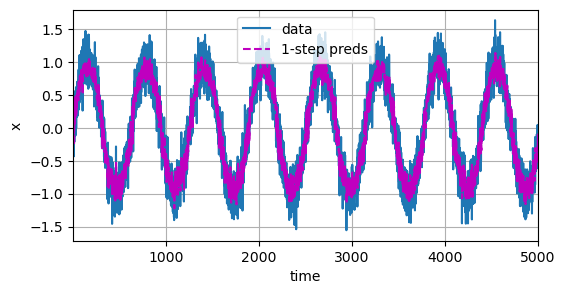

In [5]:
# 1.5 模型进行单步预测
# 这里将测试样本点从训练集的前600个点延申到了5000个样本

#测试：
T = 5000  # 用于测试，产生5000个点
time_steps = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time_steps) + torch.normal(0, 0.2, (T,))

tau = 4
test_features = torch.zeros((T - tau, tau))
for i in range(tau):
    test_features[:, i] = x[i: T - tau + i]

# 原始数据
onestep_preds = net(test_features)

import matplotlib.pyplot as plt
import numpy as np
import torch

d2l_plot([time_steps, time_steps[tau:]],
     [x, onestep_preds],
     xlabel='time',
     ylabel='x',
     legend=['data', '1-step preds'],
     xlim=[1, 5000],
     figsize=(6, 3))


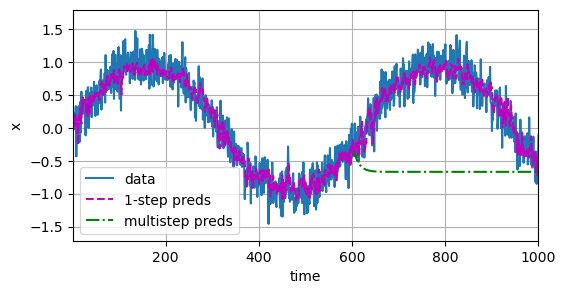

In [6]:
# 1.6 模型进行无限步预测：从600样本点开始直到结束
multistep_preds = torch.zeros(T)
# 在前 n_train + tau 个位置，直接用真实数据 x 填充。
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    # 这里代表之后的预测值，都是根据之前的预测值来的，而不是真实值
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l_plot([time_steps, time_steps[tau:], time_steps[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

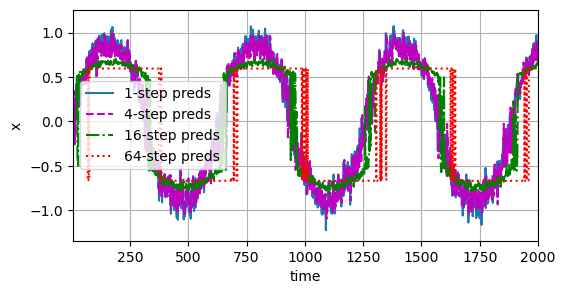

In [7]:
# 1.7 模型进行多步预测

max_steps = 64

# 例如 时间序列   x=[1,2,3,4,5,6,7,8]
# features = [[1, 2, 0, 0, 0],
#             [2, 3, 0, 0, 0],
#             [3, 4, 0, 0, 0],
#             [4, 5, 0, 0, 0]]
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# net(features[:, i - tau:i])适用于产生单步预测的结果，这里的输入数据可能夹杂着非ground truth数据。
# 每次都是用tau个样本进行单步预测：[i - tau:i]; 之后取的N步预测结果只需要取对应的列即可，例如上面例子的第三列是单步预测，第四列是双步预测。
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l_plot([time_steps[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 2000],
         figsize=(6, 3))

## 2. 词汇表+语料库

In [8]:
# 2.1 词汇表构建

# 打印并测试一窥vocab的逻辑
import re
import requests

# 如果本地没有文件就下载
import os

# 加载并清洗文本
# 读取数据
lines = read_time_machine()

# 打印前几行
print(lines[0])
print(lines[10])

tokens = tokenize(lines)
# 打印前11行tokens
for i in range(11):
    # 查看按照word tokenized的tokens;
    print(tokens[i])

# 创建词汇表，所有行的tokens都杂糅在一起
vocab = Vocab(tokens)
# 这里idx_to_token是一个列表； token_to_idx是一个map
# 打印 前 10 项 token-index map对
print(list(vocab.token_to_idx.items())[:10])

# 打印第0行和第10行的tokens，再打印这些tokens对应的id
for i in [0,10]:
    print("words", tokens[i])
    print("indices", vocab[tokens[i]])

the time machine by h g wells
twinkled and his usually pale face was flushed and animated the
['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
words ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices [1, 19, 50, 40, 2183, 2184, 400]
words ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


corpus: [1, 19, 50, 40, 2183, 2184, 400, 2, 1, 19]
['the', 'time', 'machine', 'by', 'h', 'g', 'wells', 'i', 'the', 'time']
词元数量： 32775
词汇表大小： 4580
0: <unk>
1: the
2: i
3: and
4: of
5: a
6: to
7: was
8: in
9: that
[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


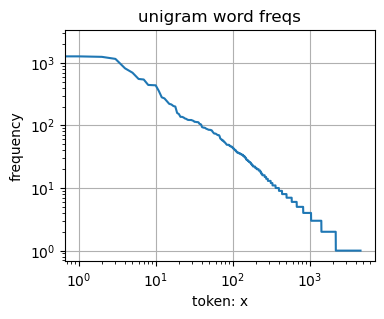

('of', 'the') 309
('in', 'the') 169
('i', 'had') 130
('i', 'was') 112
('and', 'the') 109
('the', 'time') 102
('it', 'was') 99
('to', 'the') 85
('as', 'i') 78
('of', 'a') 73


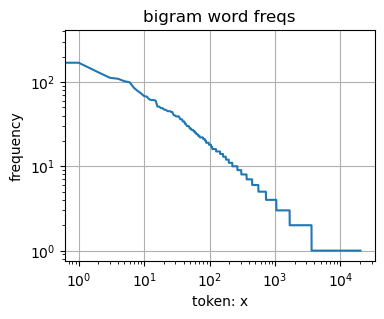

('the', 'time', 'traveller') 59
('the', 'time', 'machine') 30
('the', 'medical', 'man') 24
('it', 'seemed', 'to') 16
('it', 'was', 'a') 15
('here', 'and', 'there') 15
('seemed', 'to', 'me') 14
('i', 'did', 'not') 14
('i', 'saw', 'the') 13
('i', 'began', 'to') 13


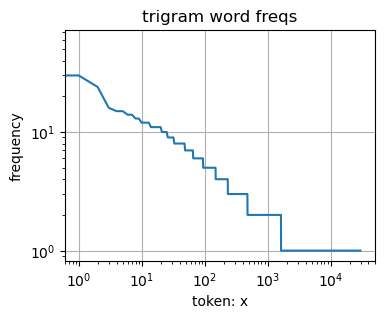

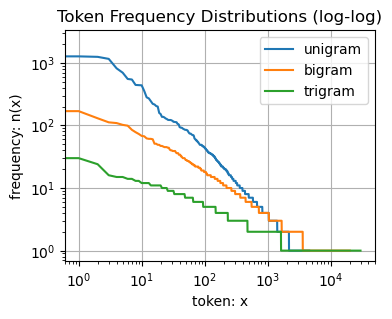

In [34]:
# 2.1 语料库构建 + 数据探索

# 封装语料库（corpus）和词汇表（vocab）
# corpus表示每个token对应的index，是所有的词元，是一个时序的序列
corpus, vocab = load_corpus_time_machine()


# 数据探索
print("corpus:", corpus[:10])
print(vocab.to_tokens(corpus[:10]))
print("词元数量：", len(corpus))
print("词汇表大小：", len(vocab))

# 查看词汇表中的前10个单次
for idx, token in enumerate(vocab.idx_to_token[:10]):
    print(f'{idx}: {token}')

def plot_token_freqs(freqs, title="Token Frequency Distribution (Log-Log)", figsize=(4, 3)):
    """
    绘制 token 频率分布（对数-对数坐标）

    参数
    ----
    freqs : list 或 numpy.ndarray
        频率列表，例如 [1000, 500, 300, ...]
    title : str
        图表标题
    figsize : tuple
        图表大小
    """
    plt.figure(figsize=figsize)
    plt.plot(freqs)
    plt.xlabel('token: x')
    plt.ylabel('frequency')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.title(title)
    plt.show()

# 探索词频

# 查看“单个单词”的词汇表的频率
freqs = [freq for token, freq in vocab.token_freqs]
# 打印输出“最频繁出现”的10个词
print(vocab.token_freqs[:10])
plot_token_freqs(freqs, "unigram word freqs")

# 连续出现的两个词元：
# 因为需要获得的是连续的两个单词，因此他们之间彼此相连，而不是笛卡尔积
# corpus[:-1] = 除最后一个元素； corpus[1:]除第一个元素
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
for (pair, freq) in bigram_vocab.token_freqs[:10]:
    words = (vocab.to_tokens(pair[0]), vocab.to_tokens(pair[1]))
    print(words, freq)
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
plot_token_freqs(bigram_freqs, "bigram word freqs")

# 连续出现的三个词元：
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
for (triple, freq) in trigram_vocab.token_freqs[:10]:
    words = (vocab.to_tokens(triple[0]), vocab.to_tokens(triple[1]), vocab.to_tokens(triple[2]))
    print(words, freq)
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plot_token_freqs(trigram_freqs, "trigram word freqs")

# 合并曲线：
plt.figure(figsize=(4, 3))
plt.plot(freqs, label='unigram')
plt.plot(bigram_freqs, label='bigram')
plt.plot(trigram_freqs, label='trigram')
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.title("Token Frequency Distributions (log-log)")
plt.show()

### 语言模型（Language Model）

给定文本序列 $( x_1, \ldots, x_T )$，语言模型的目标是估计联合概率：$p(x_1, x_2, \ldots, x_T)$

#### 它的应用包括：
- **做预训练模型**（例如 BERT，GPT-3）-- 参考最后的附加说明md
- **生成文本**：给定前面几个词，不断地使用
  $$
  x_t \sim p(x_t \mid x_1, \ldots, x_{t-1})
  $$
  来生成后续文本
- **判断多个序列中哪个更常见**，例如：
  - "to recognize speech"
  - vs
  - "to wreck a nice beach"

> 语言模型的核心是建模自然语言的概率分布，可用于预测、生成和评估句子的自然性。


### 语言模型分类：马尔可夫模型(n 元语法 n-gram language model)与拉普拉斯平滑笔记

#### 一、马尔可夫模型（Markov Model）

马尔可夫假设是语言建模中常用的一种简化假设，假设当前时刻的状态仅依赖于有限的前几个状态。

若有：

$$
P(x_{t+1} \mid x_t, x_{t-1}, \dots, x_1) = P(x_{t+1} \mid x_t)
$$

则称该序列满足一阶马尔可夫性质。

随着所依赖的历史长度增加，马尔可夫模型就拓展为高阶马尔可夫模型。

n-gram 模型是基于马尔可夫假设的语言建模方法，用于估计一个词序列出现的概率。

##### 1. 联合概率展开

以 4 元语法为例：

- 无条件独立（Unigram）模型：

    $$
    P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2)P(x_3)P(x_4)
    $$

- 一阶马尔可夫（二元语法，Bigram）模型：

    $$
    P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2 \mid x_1)P(x_3 \mid x_2)P(x_4 \mid x_3)
    $$

- 二阶马尔可夫（三元语法，Trigram）模型：

    $$
    P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2 \mid x_1)P(x_3 \mid x_1, x_2)P(x_4 \mid x_2, x_3)
    $$

##### 2. 具体而言：

- Unigram（一元语法）模型：假设每个词独立出现
- Bigram（二元语法）模型：考虑相邻两个词之间的关系
- Trigram（三元语法）模型：考虑相邻三个词之间的关系

#### 二、拉普拉斯平滑（Laplace Smoothing）

拉普拉斯平滑是一种常见的平滑策略，在估计概率时，避免因为某些词语没有出现而导致概率为 0 的问题。

##### 1. 公式定义

设训练集中：

- $n(x)$ 表示词 $x$ 出现的次数
- $n(x, x')$ 表示 $x$ 后跟 $x'$ 的次数
- $n(x, x', x'')$ 表示三元组的次数
- $n$ 为总词数，$m$ 为词汇表大小
- $\epsilon_1, \epsilon_2, \epsilon_3$ 为超参数

则：

- 一元语法平滑概率：

    $$
    \hat{P}(x) = \frac{n(x) + \epsilon_1 / m}{n + \epsilon_1}
    $$

- 二元语法平滑概率：

    $$
    \hat{P}(x' \mid x) = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}
    $$

- 三元语法平滑概率：

    $$
    \hat{P}(x'' \mid x, x') = \frac{n(x, x', x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}
    $$

##### 2. 解释

- 当 $\epsilon = 0$：无平滑，出现过的事件才有概率，未出现的为 0。
- 当 $\epsilon \to \infty$：趋向于均匀分布，即所有词概率都接近 $1/m$。
- 拉普拉斯平滑可以看作将每个词的出现次数加上一个常数，从而避免概率为 0 的问题。


## 两种建模方法：
### 1. 随机采样 (Random Sampling)

#### 特点
- 每个 batch 里，子序列的起始位置是随机的。
- 子序列之间相互独立，没有上下文连续性。

#### 优点
- 打破相关性：训练样本之间独立，有利于随机梯度下降 (SGD) 的收敛。
- 多样性强：每次迭代时抽到的数据分布不一样，能提高泛化能力。
- 实现简单：只要从 corpus 里切块，不需要维护跨 batch 的状态。

#### 缺点
- 上下文丢失：相邻 batch 之间没有连续性，模型学不到长距离依赖。
- 状态无法传递：在训练 RNN 时，通常需要把隐藏状态初始化为零。
  - 因为 batch 内样本是随机的，没法把上个 batch 的 hidden state 传下来。

### 2. 顺序分区 (Sequential Partitioning)

#### 特点
- 把 corpus 按顺序分割成多个长序列，然后再切成小片段。
- batch 内的样本保持时间顺序，跨 batch 也能拼接成连续序列。

#### 优点
- 保持上下文连续性：特别适合训练 RNN，可以传递隐藏状态 (hidden state) 跨 batch。
- 有利于学习长依赖：模型能“记住”更远的历史，不用每次都重置状态。
- 更接近真实应用场景：自然语言就是连续的。

#### 缺点
- 样本相关性强：不同 batch 高度相关，SGD 的“随机性”不足，收敛可能慢一些。
- 多样性不足：模型可能过拟合局部模式，需要额外 regularization 或更大语料缓解。

### 3. 什么时候用哪种？

- **随机采样**：
  - 用于快速实验、小模型或训练早期。
  - 不依赖跨 batch 状态时更方便。
  - 适合 Transformer 这类“不保存状态”的模型。

- **顺序分区**：
  - 用于 RNN / LSTM / GRU，需要跨时间传递 hidden state。
  - 适合长文本建模，想捕捉长依赖时更有优势。
  - 训练更贴近语言真实结构。


In [36]:
# 试验样本生成的效果：
#   batch_size=2表示每个batch用到两个sequence;
#   样本不重叠，Y是样本的对应下一个位移。

my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

print("-------------------------")
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  tensor([[ 1,  2,  3,  4,  5],
        [26, 27, 28, 29, 30]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [27, 28, 29, 30, 31]])
X:  tensor([[11, 12, 13, 14, 15],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [ 7,  8,  9, 10, 11]])
X:  tensor([[21, 22, 23, 24, 25],
        [16, 17, 18, 19, 20]]) 
Y: tensor([[22, 23, 24, 25, 26],
        [17, 18, 19, 20, 21]])
-------------------------
X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


### 小结
元语法通过截断相关性，为处理长序列提供了一种实用的模型。

齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他
元语法。

长序列存在一个问题：它们很少出现或者从不出现。通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词词组。

读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。

英语在NLP中用词根做的比较多，而不是分词或者是char.

### 补充：齐普夫定律 (Zipf’s Law)

#### 1. 定义
在自然语言里，把所有词按出现频率从高到低排序，某个词的频率和它的排名大致成反比。

公式表示：

$$
f(r) \propto \frac{1}{r^s}, \quad s \approx 1
$$

其中：
- $f(r)$：排名第 $r$ 的词的频率
- $r$：词频排名（1 表示最高频词）
- $s$：常数，通常接近 1

#### 2. 举例
以英语语料为例：

- 第 1 名词 **"the"** 占总词数的 ~7%
- 第 2 名 **"of"** 占 ~3.5%（大约 1/2）
- 第 10 名 **"and"** 占 ~0.7%（大约 1/10）
- 第 100 名词频 ≈ 第 1 名的 1/100

也就是说：排名第 $k$ 的词频 ≈ 第 1 名的 $1/k$。

### 问题：
### 1. 四元语法需要存储多少个词频？

- **单词频率 (Unigram)：**
  总共有 $100{,}000$ 个单词 → 需要存储 $100{,}000$ 个 unigram 频率。

- **相邻四词频率 (4-gram)：**
  理论上可能的组合数是：

  $$
  (100{,}000)^4
  $$

  但实际上只存储语料中出现过的 4-gram，远少于理论上限。

**因此需要存储：**
- $100{,}000$ 个 unigram 频率
- 语料中实际出现的 4-gram 频率

---

### 2. 我们如何对一系列对话建模？

可以把对话当作一个长序列，用 **语言模型 (LM)** 来建模：

- **Unigram** → 只考虑单词自身频率
- **Bigram / Trigram** → 考虑前 1、2 个上下文
- **RNN / Transformer** → 捕捉更长的上下文依赖

**常见方法：**
- 基于 n-gram 的统计语言模型
- 基于神经网络（RNN, LSTM, GRU）
- 基于 Transformer（GPT、BERT）

---

### 3. 不同 n-gram 的齐普夫定律指数

一元语法、二元语法和三元语法的 **Zipf’s Law 指数不同**。
通过比较不同 n-gram 的 Zipf 分布曲线，可以估计：

- 语言的冗余度（higher-order n-gram 更稀疏）。
- 数据稀疏性随 n 增大而加剧，需要平滑。
- Zipf 指数的变化反映了词汇多样性和上下文依赖程度。

---

### 4. 读取长序列数据的其他方法

除了 **随机采样** 和 **顺序分区**，还有：

- **按句子/段落切分**：保证样本是完整句子。
- **滑动窗口**：子序列之间重叠。
- **变长序列截断/填充**：每个 batch 动态对齐不同长度序列。
- **Bucketing（分桶）**：按长度把句子分组，减少填充浪费。

---

### 5. 随机偏移量的思考

#### (1) 为什么随机偏移量是个好主意？
- 避免每次都从 `corpus[0]` 开始，提升样本多样性。
- 减少模型过拟合于固定位置。

#### (2) 它真的会实现完美均匀分布吗？
- 不会。
- 随机偏移只是让起点多样化，但长序列仍有边界效应。

#### (3) 怎么做更均匀？
- 在多个 epoch 中多次随机化 offset。
- 使用 **sliding window** 或 **dynamic batching**，覆盖更全面。
- 数据增强（shuffle 文档顺序）。

---

### 6. 完整句子采样带来的问题与解决方法

**问题：**
- 不同句子长度不同 → batch 内样本长度不统一。
- 需要 **padding**，浪费计算并影响效率。

**解决方法：**
- **padding + mask**：统一长度，忽略 padding 的损失。
- **bucketing（分桶采样）**：把长度相似的句子放一起，减少 padding。
- **dynamic batching**：动态调整 batch size，使每个 batch 的 token 数量接近固定值。



## RNN循环神经网络

In [40]:
# 隐状态更新简便实现： 拼接输入和上一层的隐状态； 拼接权重
# 实验：
import torch


X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
print("未拼接：")
print(torch.matmul(X, W_xh) + torch.matmul(H, W_hh))
print("-----------")
print("拼接：")
print(torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0)))

未拼接：
tensor([[-1.9792,  0.3445, -0.8973, -1.9184],
        [ 3.5505,  3.7708, -1.4467, -1.4762],
        [ 0.3990, -1.2713, -1.5230,  1.7049]])
-----------
拼接：
tensor([[-1.9792,  0.3445, -0.8973, -1.9184],
        [ 3.5505,  3.7708, -1.4467, -1.4762],
        [ 0.3990, -1.2713, -1.5230,  1.7049]])


In [10]:
%matplotlib inline
import math
import torch
from torch import nn
import os

from torch.nn import functional as F
from ml_model_utils import *

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [11]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [12]:
# 为了定义循环神经网络模型， 我们首先需要一个init_rnn_state函数在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）。 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [13]:
# 下面的rnn函数定义了如何在一个时间步内计算隐状态和输出。 循环神经网络模型通过inputs最外层的维度实现循环， 以便逐时间步更新小批量数据的隐状态H。 此外，这里使用tanh函数作为激活函数。 如 4.1节所述， 当元素在实数上满足均匀分布时，tanh函数的平均值为0。
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [14]:
# __init__: vocab_size: 词表大小，用于 one-hot 编码。
#     num_hiddens: 隐藏层的维度（隐藏状态的大小）。
#     device: 使用的设备（如 cpu() 或 cuda()）。
#     get_params: 一个函数，返回模型所需的参数（权重、偏置等）。
#     init_state: 一个函数，用于初始化 RNN 的隐藏状态。
#     forward_fn: 前向传播函数，定义 RNN 的核心计算逻辑。

# __call__
#     定义对象可以被当作函数调用：output, new_state = model(X, state)
#     X: 输入张量，形状为 (batch_size, num_steps)，表示一个 batch 的多个时间步。
#     state: 当前的隐藏状态。


class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        # X.T: 转置，将输入形状从 (batch_size, num_steps) 变为 (num_steps, batch_size)，因为我们按时间步处理。
        # F.one_hot(X.T, self.vocab_size): 对每个时间步和样本中的 token 进行 one-hot 编码，结果形状为 (num_steps, batch_size, vocab_size)。
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [15]:
X = torch.arange(20).reshape((4, 5))
F.one_hot(X.T, 28).shape

num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], try_gpu())
Y, new_state = net(X.to(try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([20, 4580]), 1, torch.Size([4, 512]))

### 从语言模型到预训练模型

**预训练模型**：用大规模语料，把语言模型训练到“足够懂语言”的程度，然后再迁移到下游任务。

#### 经典方法

##### 1. 自回归语言模型 (Autoregressive LM) —— GPT 系列

- **思路**：只预测下一个词。
- **模型**：Transformer Decoder 堆叠。
- **目标函数**：最大化

$$
\prod_{t=1}^{T} p(x_t \mid x_1, \dots, x_{t-1})
$$

- **结果**：学会了“生成文本”的能力（对话、写作）。

##### 2. 自编码语言模型 (Autoencoding LM) —— BERT 系列

- **思路**：遮盖（mask）掉输入的部分词，让模型预测被遮盖的词。
- **训练目标**：Masked Language Model (MLM)

$$
\max \; p(x_{\text{masked}} \mid x_{\text{unmasked}})
$$

- **结果**：学会了“理解文本”的能力（分类、问答）。

##### 3. 其他预训练方式

- **Next Sentence Prediction (BERT)**：判断句子 B 是否紧跟句子 A。
- **Sentence Order Prediction (ALBERT)**：判断两句话是否顺序颠倒。
- **Span Corruption (T5)**：遮盖连续片段，让模型填空。

#### 为什么语言模型能预训练？

语言模型的训练目标 **不依赖人工标注**，只需要大量原始文本（自监督学习）。
通过预测下一个词或被 mask 的词，模型学到：

- 词的语义（分布相似的词往往语义接近）。
- 语法结构（什么词能跟在什么后面）。
- 上下文关系（如何跨句子、跨段落理解语境）。

这些知识对几乎所有 NLP 下游任务都有帮助。

#### 从预训练到下游任务

- **预训练阶段**：在大规模语料（Wikipedia, BooksCorpus, WebText 等）上训练 LM。
- **微调阶段**：把预训练好的模型迁移到具体任务，比如：
  - 分类（情感分析、垃圾邮件检测）
  - 问答（SQuAD）
  - 翻译（NMT）
  - 对话（ChatGPT）

**方式一般有两种**：
1. Feature-based（用预训练的 embedding 特征）
2. Fine-tuning（在下游任务上继续训练整个模型）
